In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC


In [2]:
import sklearn
sklearn.__version__

'1.7.2'

## Зачем нужна калибровка классификатора

Хорошо откалиброванные классификаторы - этоклассификаторы прогнозирующие вероятность принадлежности к определенному классу. Для данных классификаторов  выходные данные с `predict_proba` могут быть непосредственно интерпретированы как вероятность. 

Например, хорошо откалиброванный (бинарный) классификатор должен классифицировать данные таким образом, чтобы для строк, для которых он выдал значение `predict_proba`, близкое к 0,8, примерно 80% фактически принадлежали к указанному классу, а 20% к противоложному.

В этом примере мы сравним результаты  `predict_proba` четырех различных моделей: 
- логистической регрессии,
- гауссовой наивной байесовской модели,
- случайного лесного классификатора,
- линейной SVM.
и посмотрим, что же они реально предсказывают.

Где нужна калибровка:
1. Для правильного понимания, насколько результатам алгоритма можно доверять. Это важно при интерпретации моделей, а также для принятия решений о внедрении систем ML, ИИ и анализа их работы.
2. Для более точного решения задач ML и ИИ в целом, при условии, что ее результатами кользуются другие модели. Например, уверенности часто используются другими алгоритмами, например в языковых моделях. При генерации текстов используются вероятности появления отдельных токенов.
3. Для настройки скоринговых функций ошибки, одной из которых является логистическая регрессия.


### Демонстрационный датасет

Мы будем использовать синтетический набор данных бинарной классификации со 100 000 выборками
и 20 функций. Из 20 функций только 2 являются информативными, 2 -
избыточными (случайные комбинации информативных функций) и
оставшиеся 16 неинформативны (случайные числа).

Из 100 000 образцов 100 будут использованы для подбора модели, а остальные
для тестирования. 

Обратите внимание, что подход не является стандартным и его цель состоит в том, чтобы получить
стабильные оценки калибровочной кривой для моделей, которые потенциально подвержены
переобучению. 

На практике лучше использовать перекрестную проверку с большим количеством
сбалансированных разделений, но это сделало бы код в этом примере более сложным
для понимания.

In [3]:
X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

**Важный коментарий про SVC**
В SVC уже сокрыта калибровка при выборе `probability = True` поэтому мы ее обойдем через написние своей функции.

In [4]:
class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

class NaivelyCalibratedSVC(SVC):
    """SVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [5]:
lr = LogisticRegressionCV(Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000)
gnb = GaussianNB()
svc = NaivelyCalibratedSVC(C=1.0, kernel = 'linear')
rfc = RandomForestClassifier(random_state=42)

clf_list = [
    (lr, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (svc, "LinearSVC"),
    (rfc, "Random forest"),
]

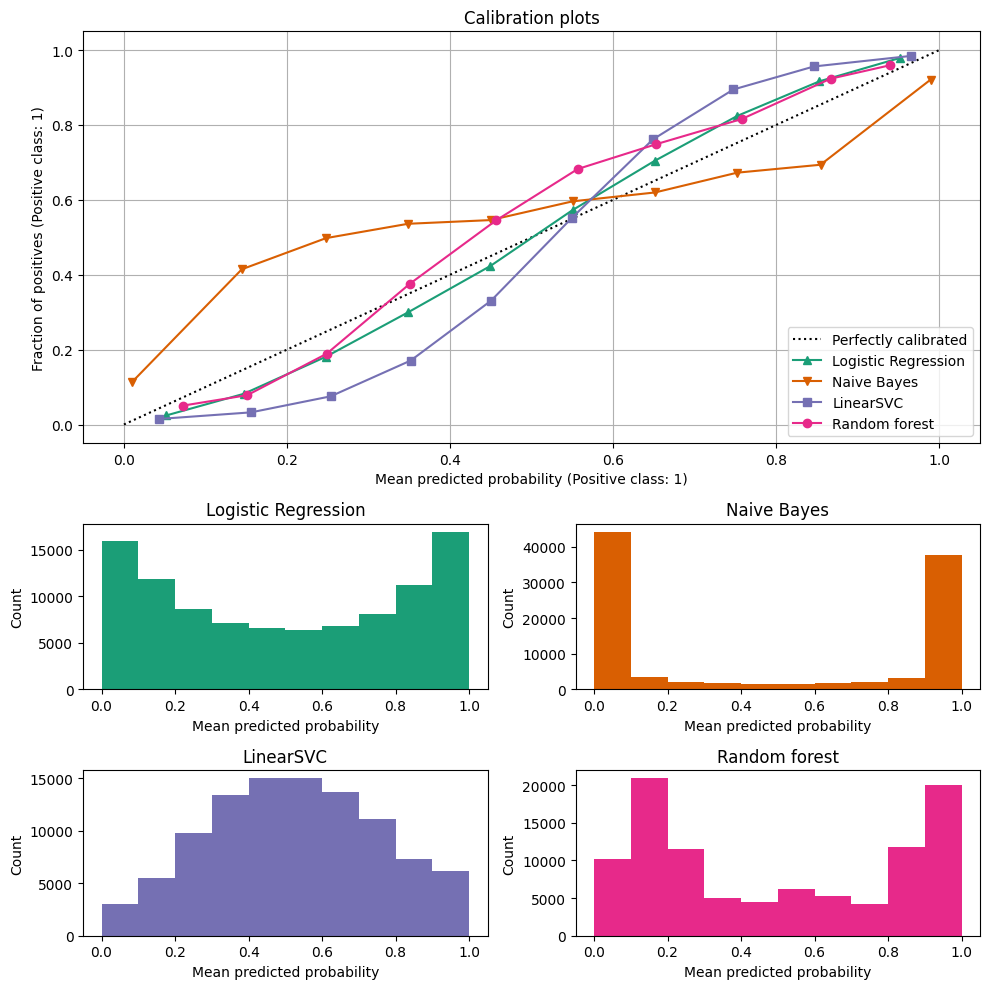

In [6]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
        #density=True
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

`LogisticRegressionCV` выдает достаточно хорошо откалиброванные прогнозы, несмотря на небольшой размер обучающего набора: его кривая надежности находится ближе всего к диагонали среди четырех моделей.

Логистическая регрессия обучается путем минимизации логарифмических потерь, что является самым корректным для не правилом определения штафа обучения: в ограниченном количестве обучающих данных данный подход позволяет предсказывает(теоретически) истинные условные вероятности. </br>
Таким образом, эта (гипотетическая) модель была бы идеально откалибрована. </br>
Однако использование правильного штрафа при обучения само по себе недостаточно для обеспечения хорошей калибровки модели: даже при очень большом наборе обучающих данных логистическая регрессия все равно может быть плохо откалибрована, если она была слишком сильно упорядочена или если выбор и предварительная обработка входных признаков привели к неправильным параметрам этой модели (например, если истинная граница принятия решения для набора данных является нелинейной функцией входных объектов).

В этом примере обучающий набор был намеренно очень мал. При такой настройке оптимизация по `log_loss` все равно может привести к некачественной калибровке моделей из-за переобучения. Чтобы "смягчить" это,  использована `LogisticRegressionCV` был настроен на настройку параметра регуляризации `C`, чтобы также минимизировать потери с помощью внутренней перекрестной проверки и найти наилучший компромисс для этой модели при применении небольшого обучающего набора.

Из-за ограниченного размера обучающей выборки и отсутствия гарантии точной спецификации модели наблюдается, что калибровочная кривая модели близка, но не идеально расположена по диагонали. Форму калибровочной кривой этой модели можно интерпретировать как слегка недостоверную.

`GaussianNB` имеет тенденцию **увеличивать** вероятности до 0 или 1 (см. гистограмму) 
в этом конкретном наборе данных (чрезмерная самоуверенность - over-confident).</br>

***Чрезмерная самоуверенность - over-confident предсказано слишком много 1 по сравнению с истиной картиной, поэтому точки смешены ниже пунктирной линии для 1, и слишком много 1 для правой части (выше пунктирной линии).***

Это происходит главным образом потому, что наивное уравнение Байеса дает правильную оценку вероятностей только тогда, когда выполняется предположение об условной независимости признаков. Однако признаки могут быть коррелированы, и это относится к данному набору данных, который содержит 2 признака, сгенерированных в виде случайных линейных комбинаций информативных признаков. </br>
Эти коррелированные признаки фактически "подсчитываются дважды", в результате чего прогнозируемые вероятности приближаются к 0 и 1. 

Важно понимать, что изменение `random_state`, используемого для генерации набора данных, может привести к сильно отличающимся результатам для наивной байесовской оценки.

`LinearSVC` и `SVC` не является "естественным вероятностным классификатором". Чтобы интерпретировать его предсказание как таковое, мы просто перемасштабировали выходные данные функции `decision_function` в интервал $[0, 1]$, применив минимальное и максимальное масштабирование в классе-оболочке `NaivelyCalibrated...`, определенном выше. </br>
Этот эстиматор показывает типичную сигмовидную калибровочную кривую для этих данных: 
- предсказания, превышающие 0.5, соответствуют выборкам с еще большей эффективной долей положительного класса (выше диагонали)
- предсказания, меньшие 0.5, соответствуют еще более низким долям положительного класса (ниже диагонали). 

Такие неуверенные прогнозы  (чрезмерная неуверенность - under-confident) типичны для методов с максимизацией зазора.

Гистограмма прогнозирования `RandomForestClassifier` показывает пики с вероятностью приблизительно `0.2` и `0.9`, в то время как вероятности, близкие к 0 или 1, встречаются очень редко. Объяснение этому дано в [Predicting good probabilities with supervised learning](https://dl.acm.org/doi/abs/10.1145/1102351.1102430): “Такие методы, как , бэггинг и случайные леса, которые усредняют прогнозы из базового набора моделей, могут испытывать трудности с получением прогнозов вблизи 0 и 1, поскольку дисперсия в базовых моделях будет смещать прогнозы, которые должны быть близки к нулю или отклоняться от этих значений на единицу. </br>
Поскольку предсказания ограничены интервалом [0, 1], ошибки, вызванные дисперсией, как правило, являются односторонними, близкими к нулю и единице. Например, если модель должна предсказать $p = 0$ для некоторого случая, единственный способ достичь этого с помощью суммирования - это если все деревья с суммами предсказывают ноль. Если мы добавим шум к деревьям, по которым выполняется усреднение по суммам, этот шум приведет к тому, что некоторые деревья будут предсказывать значения, превышающие 0 для этого случая, что приведет к отклонению среднего прогноза по совокупности сумм от 0.</br>
Мы наиболее сильно наблюдаем этот эффект в случае случайных лесов, потому что деревья базового уровня, обученные с помощью случайных лесов, имеют относительно высокую дисперсию из-за поднабора признаков”. 

Этот эффект может сделать случайные леса недостаточно надежными для оценок вероятностей. **На самом деле, модель случайного леса ненамного менее достоверна для вероятностных оценок, чем модель логистической регрессии.**